# Assignment 9
Bill Henderson

CSCI-E-116

Spring 2025

# Imports

In [110]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import seaborn as sns
import numpy as np
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import root_mean_squared_error
from fredapi import Fred
from yaml import safe_load
import yfinance as yf
from arch import arch_model
from arch.univariate import ARCHInMean
import random
import matplotlib.pyplot as plt
import warnings

random.seed(42)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

## Data Ingress

In [111]:
df = pd.read_excel('ie_data.xlsx',sheet_name='Data1', dtype={'date': 'str'})
df.date = pd.to_datetime(df.date, format="%Y.%m")

In [112]:
# adjusted return column name due to syntax issues with the ols function
df.columns = ['date', 'ret', 'cape', 'trcape', 'ecy']
df = df.set_index('date').sort_index()
df.describe()

,ret,cape,trcape,ecy
count,1599.000000,1719.000000,1719.000000,1719.000000
mean,0.066570,17.450608,20.870102,0.046399
std,0.051605,7.228544,7.413732,0.043983
min,-0.059239,4.784241,6.582425,-0.025777
25%,0.033795,11.972563,15.459255,0.015935
50%,0.065448,16.518058,20.511205,0.033885
75%,0.103182,21.196450,24.744222,0.066105
max,0.199585,44.197940,48.110969,0.235340


In [113]:
train = df[df.index <= datetime(2014,3, 1)]
train.describe()

,ret,cape,trcape,ecy
count,1599.000000,1600.000000,1600.000000,1600.000000
mean,0.066570,16.532020,20.000734,0.047588
std,0.051605,6.561787,6.863677,0.045313
min,-0.059239,4.784241,6.582425,-0.025777
25%,0.033795,11.696398,15.167381,0.014625
50%,0.065448,15.937167,19.821522,0.035033
75%,0.103182,19.936850,23.811357,0.068997
max,0.199585,44.197940,48.110969,0.235340


In [114]:
test = df[df.index > datetime(2014,3,1)]
test.describe()

,ret,cape,trcape,ecy
count,0.0,119.000000,119.000000,119.000000
mean,NaN,29.801375,32.559083,0.030408
std,NaN,3.466458,3.716264,0.008044
min,NaN,24.002607,26.389562,0.014708
25%,NaN,26.828532,29.486447,0.025272
50%,NaN,29.313345,32.103122,0.031120
75%,NaN,31.375612,34.240422,0.036504
max,NaN,38.582627,42.054858,0.048801


## Part 1: OLS Model
### Model 0

In [115]:
mod0 = smf.ols(formula='ret ~ cape', data=train)
res0 = mod0.fit()
res0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     576.6
Date:                Mon, 21 Apr 2025   Prob (F-statistic):          4.82e-109
Time:                        21:39:46   Log-Likelihood:                 2717.7
No. Observations:                1599   AIC:                            -5431.
Df Residuals:                    1597   BIC:                            -5421.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1335      0.003     44.511      0.000       0.128       0.139
cape          -0.0041      0.000    -24.013      0.000      -0.004      -0.004
==============================================================================
Omnibus:                       34.335   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.147
Skew:                          -0.277   Prob(JB):                     2.84e-07
Kurtosis:                       2.619   Cond. No.                         48.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model 2

In [116]:
mod1 = smf.ols(formula='ret ~ trcape', data=train)
res1 = mod1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     626.5
Date:                Mon, 21 Apr 2025   Prob (F-statistic):          6.32e-117
Time:                        21:39:46   Log-Likelihood:                 2735.9
No. Observations:                1599   AIC:                            -5468.
Df Residuals:                    1597   BIC:                            -5457.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1464      0.003     43.424      0.000       0.140       0.153
trcape        -0.0040      0.000    -25.030      0.000      -0.004      -0.004
==============================================================================
Omnibus:                       40.757   Durbin-Watson:                   0.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.066
Skew:                          -0.355   Prob(JB):                     1.99e-09
Kurtosis:                       2.686   Cond. No.                         65.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model 2

In [117]:
mod2 = smf.ols(formula='ret ~ ecy', data=train)
res2 = mod2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     821.5
Date:                Mon, 21 Apr 2025   Prob (F-statistic):          4.07e-146
Time:                        21:39:46   Log-Likelihood:                 2803.1
No. Observations:                1599   AIC:                            -5602.
Df Residuals:                    1597   BIC:                            -5591.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0350      0.002     23.000      0.000       0.032       0.038
ecy            0.6635      0.023     28.662      0.000       0.618       0.709
==============================================================================
Omnibus:                       36.522   Durbin-Watson:                   0.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.466
Skew:                          -0.343   Prob(JB):                     1.21e-08
Kurtosis:                       2.722   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model 3

In [118]:
mod3 = smf.ols(formula='ret ~ trcape + ecy', data=train)
res3 = mod3.fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     457.3
Date:                Mon, 21 Apr 2025   Prob (F-statistic):          9.81e-158
Time:                        21:39:46   Log-Likelihood:                 2833.5
No. Observations:                1599   AIC:                            -5661.
Df Residuals:                    1596   BIC:                            -5645.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0782      0.006     13.729      0.000       0.067       0.089
trcape        -0.0017      0.000     -7.864      0.000      -0.002      -0.001
ecy            0.4752      0.033     14.395      0.000       0.410       0.540
==============================================================================
Omnibus:                       43.071   Durbin-Watson:                   0.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.741
Skew:                          -0.406   Prob(JB):                     1.17e-10
Kurtosis:                       2.834   Cond. No.                         686.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model Comparison
In regards to statistical significance, all four models have significant variables for all their dependent variables, showing very low p values of zero. As far as AIC and R squared values, the fourth model has the lowest AIC and the highest R squared, showing a better fit than the others. Taking into account these observations, the the fourth model (mod3) appears to be the best fit while having statistically significant variables. 

# Part 2: Rolling OLS Model
## Data Manipulation

In [119]:
train_set = df[df.index <= datetime(1999,12,1)]
train_set.describe()

,ret,cape,trcape,ecy
count,1428.000000,1428.000000,1428.000000,1428.000000
mean,0.066548,15.480452,19.105276,0.049932
std,0.052334,5.802717,6.366572,0.046998
min,-0.059239,4.784241,6.582425,-0.025777
25%,0.032050,11.391310,14.693266,0.013939
50%,0.065888,15.190139,19.027924,0.037434
75%,0.103052,18.443387,22.719697,0.074570
max,0.199585,44.197940,48.110969,0.235340


In [120]:
test_set = df.loc[datetime(2001,1,1): datetime(2014,3,1),:]
test_set.describe()

,ret,cape,trcape,ecy
count,159.000000,160.000000,160.000000,160.000000
mean,0.073860,24.029618,26.112742,0.030856
std,0.038329,4.025607,4.169441,0.016049
min,-0.008182,13.323668,14.592704,0.002096
25%,0.049916,21.408226,23.578384,0.017772
50%,0.059196,23.928528,26.166466,0.031053
75%,0.110810,26.391076,28.454493,0.042579
max,0.142901,36.978868,39.712810,0.072578


## Models

In [121]:
models = ['ret ~ cape','ret ~ trcape','ret ~ ecy','ret ~ trcape + ecy']

roll_mods = [ 
    RollingOLS.from_formula(model, data=train_set, window = 1428)
    for model in models
]

In [122]:
coeffs= [mod.fit().params.iloc[-1,:] for mod in roll_mods]

coeffs[0]

Intercept    0.143109
cape        -0.004946
Name: 1999-12-01 00:00:00, dtype: float64

In [123]:
preds = pd.DataFrame(test_set.ret)
preds['mod0'] = coeffs[0].Intercept + (coeffs[0].cape * test_set.cape)
preds['mod1'] = coeffs[1].Intercept + (coeffs[1].trcape * test_set.trcape)
preds['mod2'] = coeffs[2].Intercept + (coeffs[2].ecy * test_set.ecy)
preds['mod3'] = coeffs[3].Intercept + (coeffs[3].ecy * test_set.ecy) + (coeffs[3].trcape * test_set.trcape)
preds =preds.dropna(axis=0)

In [124]:
print(f"RMSE ({models[0]}): {round(root_mean_squared_error(preds.ret,preds.mod0),3)}")
print(f"RMSE ({models[1]}): {round(root_mean_squared_error(preds.ret,preds.mod1),3)}")
print(f"RMSE ({models[2]}): {round(root_mean_squared_error(preds.ret,preds.mod2),3)}")
print(f"RMSE ({models[3]}): {round(root_mean_squared_error(preds.ret,preds.mod3),3)}")

RMSE (ret ~ cape): 0.055
RMSE (ret ~ trcape): 0.046
RMSE (ret ~ ecy): 0.035
RMSE (ret ~ trcape + ecy): 0.039


## Model Comparision
Looking at the RMSE values above, the `ret ~ ecy` model represented in model 2 had the best RMSE of all the models, giving more insight than just the standard deviation of the test annual compunded real return which was 0.038. This model was very close to the one adding the `trcape` dependent variable, but we have better RMSE and a simpler model by just considering `ecy.`

# Part B: GARCH Model
## Data Collection

In [125]:
tesla = yf.Ticker('TSLA').history(start=datetime(2010,7,2), end=datetime.now()).Open
tesla = tesla[tesla.index.year >= 2021]
full_daterange = pd.date_range(tesla.index.min(),tesla.index.max())
tesla = tesla.reindex(full_daterange).fillna(method='bfill')
tesla.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1569 entries, 2021-01-04 00:00:00-05:00 to 2025-04-21 00:00:00-04:00
Freq: D
Series name: Open
Non-Null Count  Dtype  
--------------  -----  
1569 non-null   float64
dtypes: float64(1)
memory usage: 24.5 KB


/var/folders/yx/p_q7lg1d7l9gxgp19507kcr00000gr/T/ipykernel_84741/16692012.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tesla = tesla.reindex(full_daterange).fillna(method='bfill')


In [126]:
tesla.describe()

count    1569.000000
mean      248.316845
std        64.419308
min       103.000000
25%       202.520004
50%       239.426666
75%       279.266663
max       475.899994
Name: Open, dtype: float64

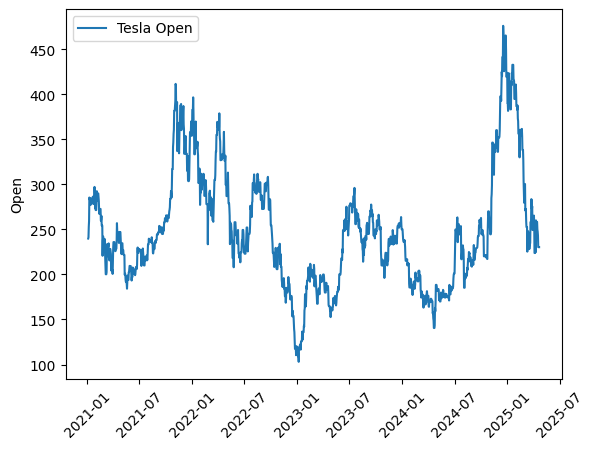

In [127]:
_ = sns.lineplot(tesla,label='Tesla Open')
_ = plt.xticks(rotation=45)

## GARCH Models
### Model 0: CARCH(1,1) without mean

In [128]:
mod0 = arch_model(tesla, p=1, q=1, vol='GARCH',mean='Zero')
res0 = mod0.fit()

print(res0.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 46301.55618970546
Iteration:      2,   Func. Count:     11,   Neg. LLF: 10829.864855770844
Iteration:      3,   Func. Count:     15,   Neg. LLF: 10829.86455770803
Iteration:      4,   Func. Count:     19,   Neg. LLF: 10829.863539446858
Iteration:      5,   Func. Count:     23,   Neg. LLF: 10829.863062588927
Iteration:      6,   Func. Count:     27,   Neg. LLF: 10829.863051467222
Iteration:      7,   Func. Count:     31,   Neg. LLF: 10829.863014563563
Iteration:      8,   Func. Count:     35,   Neg. LLF: 10829.863007046533
Iteration:      9,   Func. Count:     38,   Neg. LLF: 10829.86300704654
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10829.863007046533
            Iterations: 9
            Function evaluations: 38
            Gradient evaluations: 9
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   Open   R-squared:         

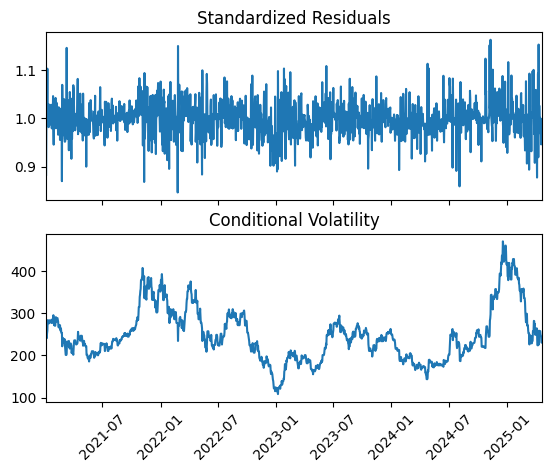

In [129]:
_ = res0.plot()
_ = plt.xticks(rotation=45)

### Model 1: GARCH (1,1) model with mean equation having ARMA(1,1) process

In [130]:
arima_model = ARIMA(tesla, order=(1, 0, 1))
arima_result = arima_model.fit()
residuals = arima_result.resid

 # Fit ARCH model to residuals
mod1 = arch_model(residuals, p=1, q=1, vol='GARCH', mean='Zero')
res1 = mod1.fit()  
print(res1.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4152982.360439253
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5476.514628782597
Iteration:      3,   Func. Count:     17,   Neg. LLF: 5465.6512549006075
Iteration:      4,   Func. Count:     22,   Neg. LLF: 483037451.0821187
Iteration:      5,   Func. Count:     28,   Neg. LLF: 5466.052311528554
Iteration:      6,   Func. Count:     33,   Neg. LLF: 5461.875647722925
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5462.05357527469
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5461.853157186224
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5461.853157179306
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5461.853157186224
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                

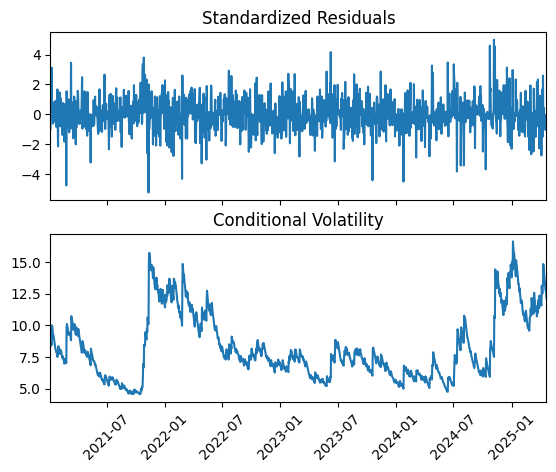

In [131]:
_ = res1.plot()
_ = plt.xticks(rotation=45)

### Model 2: GARCH (1,1) -in-mean model with mean having ARMA(1,1) process

In [132]:
mod2 = arch_model(
    residuals,
    mean='AR',
    lags=1,
    vol='GARCH',
    p=1,
    q=1,
    dist='normal'
)
res2 = mod2.fit()
print(res2.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 15957299.291344615
Iteration:      2,   Func. Count:     16,   Neg. LLF: 258078.29001097856
Iteration:      3,   Func. Count:     25,   Neg. LLF: 7294.780891648262
Iteration:      4,   Func. Count:     33,   Neg. LLF: 5472.5167620203565
Iteration:      5,   Func. Count:     40,   Neg. LLF: 5465.336097966438
Iteration:      6,   Func. Count:     47,   Neg. LLF: 5461.706794889311
Iteration:      7,   Func. Count:     54,   Neg. LLF: 5477.546492211686
Iteration:      8,   Func. Count:     61,   Neg. LLF: 5460.0982269470405
Iteration:      9,   Func. Count:     68,   Neg. LLF: 5488.64737276897
Iteration:     10,   Func. Count:     75,   Neg. LLF: 5457.81275535319
Iteration:     11,   Func. Count:     81,   Neg. LLF: 5457.812518994371
Iteration:     12,   Func. Count:     87,   Neg. LLF: 5457.812496926168
Iteration:     13,   Func. Count:     93,   Neg. LLF: 5457.812496145723
Optimization terminated successfully    (Exit mode 0)
        

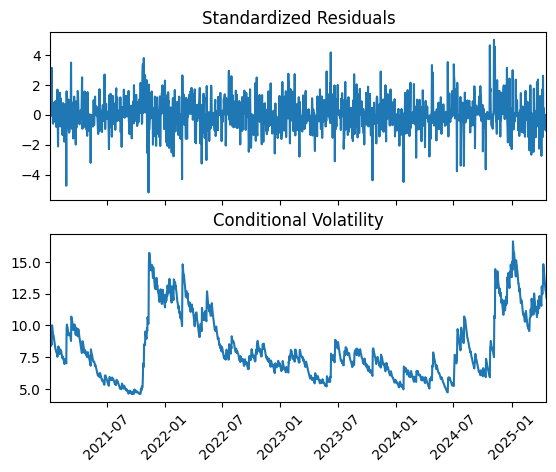

In [133]:
_ = res2.plot()
_ = plt.xticks(rotation=45)

### Analysis
As far as AIC comparison, models one and two have the lowest AIC, but I'd argue that model one is a simpler model and would edge out the other. As far as statistic significance, model one has the benefit of a zero mean reflection in the model, so only the variable components are reflected, all of which are statistically siginificant, model two has the mean componenets and they're p values are above 0.05, so I'd chose model one again in this aspect. All three models have relatively low standard errors and non of them have zero crossing confidence intervals. Residuals also appear to be randomly distributed on all three, with a pretty constant variance. All this being said, I'd choose model one as the best model

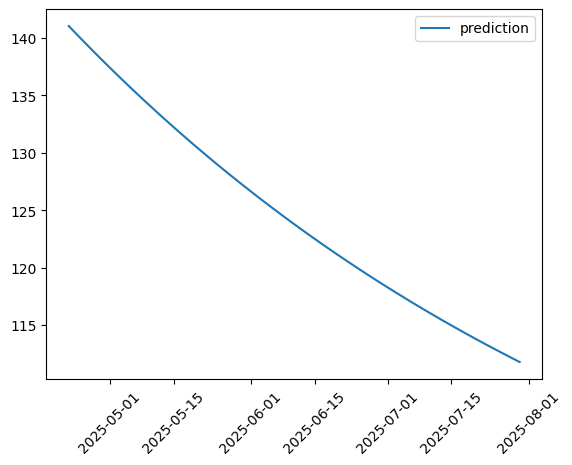

In [134]:
# Forecast GARCH component
forecast_length = 100

garch_forecast = res1.forecast(
    horizon=forecast_length
    )

vars = garch_forecast.variance

vars = vars.T
vars.columns = ['prediction']
vars.index = pd.date_range(
    start = tesla.index.max() + timedelta(days=1),
    end=tesla.index.max() + timedelta(days=forecast_length), 
    )

_ = sns.lineplot(vars)
_ = plt.xticks(rotation=45)